In [340]:
import torch
from torchvision import transforms
import torchvision
from PIL import Image
from models import FaceNetModel
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from random import sample, choice
import json
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import pandas as pd

In [248]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [249]:
root = '/home/khairulimam/datasets/lfw-mtcnn-182/'
df = pd.read_csv('datasets/lfw-mtcnn-182.csv')
classes = df['class'].unique()
class_row_counts = df['class'].value_counts()
images_above1_index = class_row_counts[class_row_counts > 2].index.tolist()
images_above1 = df[df['class'].isin(images_above1_index)]

In [250]:
state = torch.load('log/last_920.pth')
state['accuracy'], state['epoch']

(0.9207000000000001, 304)

In [251]:
model = FaceNetModel(128, 500, True)
model.load_state_dict(state['state_dict'])
model.to(device)
model = torch.nn.DataParallel(model)

In [252]:
trfrm = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
topil = transforms.ToPILImage()
totensor = transforms.Compose(trfrm.transforms[:-1])

In [331]:
def get_same_notsame(size):
    notsame = []
    same = []
    while len(same) < size:
        class_ = images_above1.sample().iloc[0]['class']
        same_pairs = images_above1[images_above1['class'] == class_].sample(2)
        same.append((same_pairs.iloc[0], same_pairs.iloc[1]))
    while len(notsame) < size:
        pair1 = images_above1.sample()
        pair2 = images_above1[images_above1['class'] != pair1.iloc[0]['class']].sample()
        notsame.append((pair1.iloc[0], pair2.iloc[0]))
    return {'same': same, 'notsame': notsame}

def get_random_pairs(size):
    pairs = []
    while len(pairs) < size:
        must_same = choice([True, False])
        if must_same:
            class_ = images_above1.sample().iloc[0]['class']
            same_pairs = images_above1[images_above1['class'] == class_].sample(2)
            pairs.append((same_pairs.iloc[0], same_pairs.iloc[1]))
        else:
            pair1 = images_above1.sample()
            pair2 = images_above1[images_above1['class'] != pair1.iloc[0]['class']].sample()
            pairs.append((pair1.iloc[0], pair2.iloc[0]))
    return pairs
    
def imshow(img,text=None,should_save=False):
    npimg = torchvision.utils.make_grid(img).numpy()
    plt.axis("off")
    if text:
        plt.text(220, 243, text, fontweight='bold', horizontalalignment='center',
            bbox=dict(facecolor='white', alpha=0.8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def get_distance(timg1, timg2):
    model.eval()
    with torch.no_grad():
        embed1 = model(timg1.unsqueeze(0))
        embed2 = model(timg2.unsqueeze(0))
    return F.pairwise_distance(embed1, embed2).item()

def get_path(root, item):
    return os.path.join(root, item['name'], item['id'] + "."+item['ext'])

In [453]:
random_pairs = get_random_pairs(30)

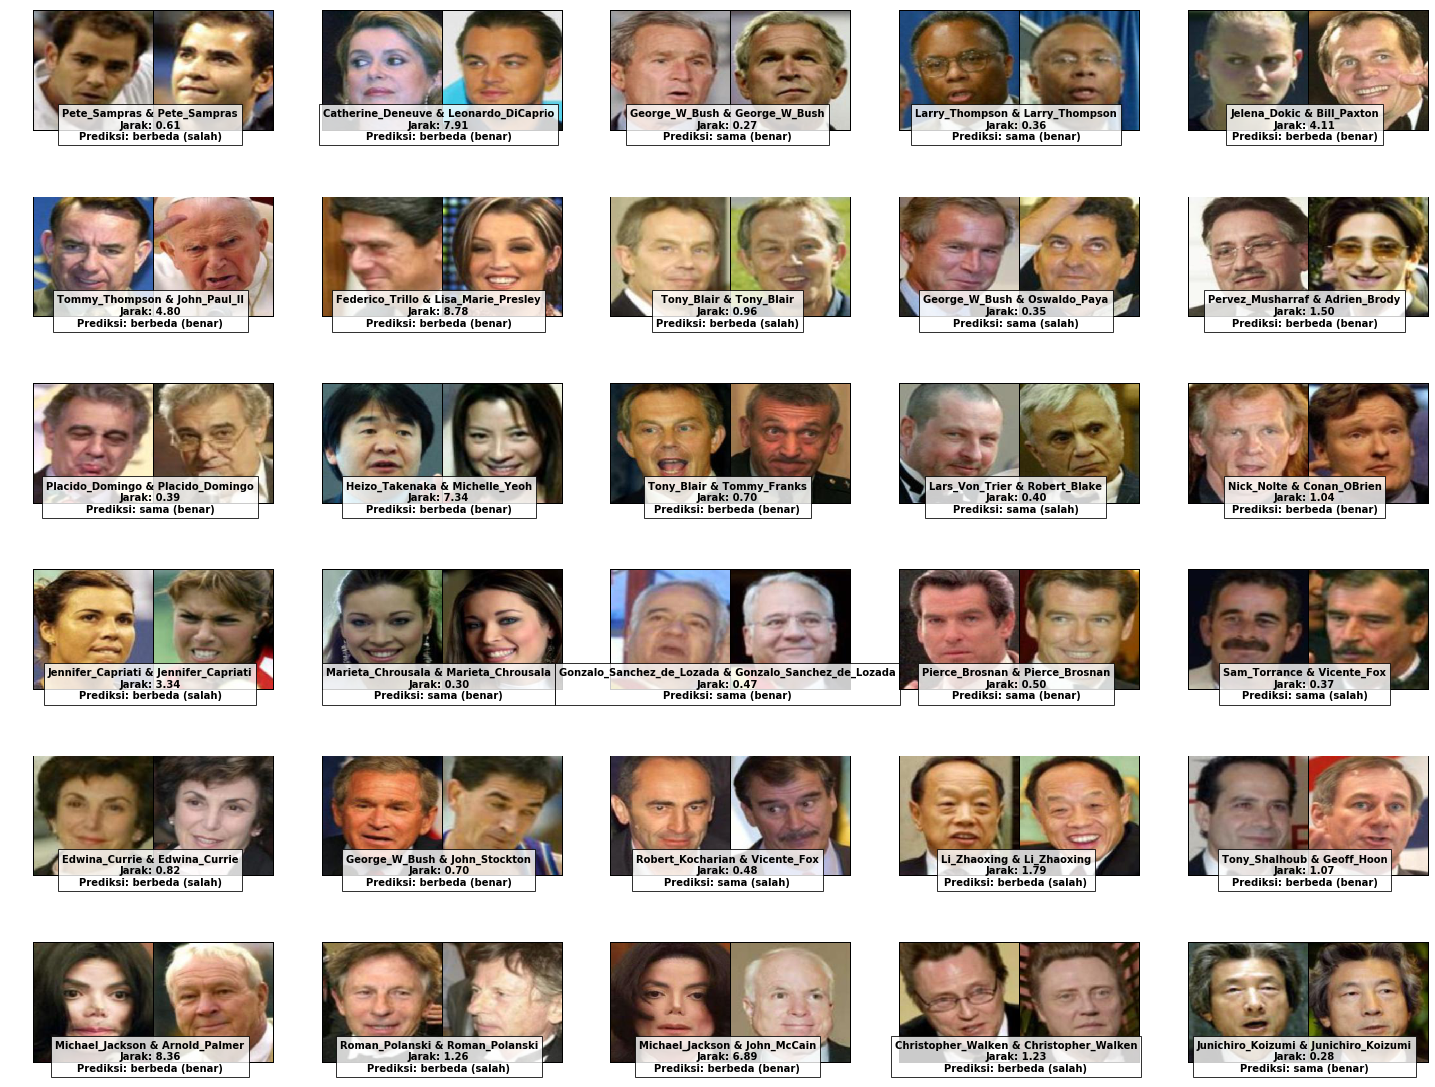

In [454]:
result = []
threshold = .6
plt.figure(figsize=(25, 20))
os.makedirs("random/"+str(threshold), exist_ok=True)
with torch.no_grad():
    for num, item in enumerate(random_pairs, 1):
        a,b = map(lambda i: trfrm(Image.open(get_path(root, i))).unsqueeze(0).to(device), item)
        x0, x1 = map(lambda i: totensor(Image.open(get_path(root, i))).unsqueeze(0), item)
        embed1, embed2 = model(a), model(b)
        concatenated = torch.cat((x0,x1),0)
        euclidean_distance = F.pairwise_distance(embed1, embed2)
        name1, name2 = item[0]['name'], item[1]['name']
        not_same = euclidean_distance > threshold
        diff_class = int(item[0]['class'] != item[1]['class'])
        pred = ("sama", "berbeda")[not_same]
        actual = ("salah", "benar")[diff_class == not_same]
        greater = ("≤", ">")[not_same]
        text = f"{name1} & {name2}\nJarak: {euclidean_distance.item():.2f}\nPrediksi: {pred} ({actual})"
        plt.subplot(6,5,num)
        imshow(concatenated, text)
plt.show()

In [455]:
result = defaultdict(list)
threshold = .5
# plt.figure(figsize=(25, 15))
with torch.no_grad():
    for threshold in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        os.makedirs("random/"+str(threshold), exist_ok=True)
        for num, item in enumerate(random_pairs, 1):
            a,b = map(lambda i: trfrm(Image.open(get_path(root, i))).unsqueeze(0).to(device), item)
            x0, x1 = map(lambda i: totensor(Image.open(get_path(root, i))).unsqueeze(0), item)
            embed1, embed2 = model(a), model(b)
            concatenated = torch.cat((x0,x1),0)
            euclidean_distance = F.pairwise_distance(embed1, embed2)
            name1, name2 = item[0]['name'], item[1]['name']
            not_same = euclidean_distance > threshold
            diff_class = int(item[0]['class'] != item[1]['class'])
            pred = ("sama", "berbeda")[not_same]
            actual = ("salah", "benar")[diff_class == not_same]
            result[threshold].append((diff_class == not_same).item())
            text = f"{name1} & {name2}\nJarak: {euclidean_distance.item():.2f}\nPrediksi: {pred} ({actual})"
#         plt.subplot(5,5,num)
#             imshow(concatenated, text)
#             plt.savefig("random/"+str(threshold)+"/random"+str(num)+".png")
#             plt.show()
# plt.show()

In [456]:
x = result.keys()
y = [sum(i) for i in result.values()]

In [457]:
x,y

(dict_keys([0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), [18, 19, 19, 18, 19, 20])

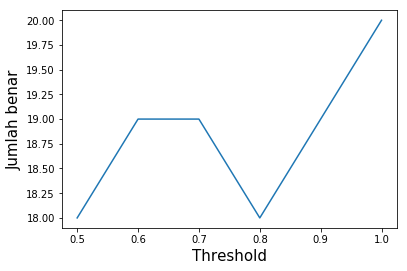

In [458]:
plt.xlabel('Threshold', fontsize=15)
plt.ylabel('Jumlah benar', fontsize=15)
plt.plot(x,y)